<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/Computational_Drug_Discovery_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bioinformatics Project - Computational Drug Discovery** **[Part 2]**

building a machine learning model using the ChEMBL bioactivity data

**Discription:**

- Calculating molecular descriptors  
- Preparing this into a dataset for model building
- Building a regression model


### Compute fingerprint descriptors

#### Download PaDEL-Descriptor

In [ ]:
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [ ]:
!unzip padel.zip

Archive:  padel.zip
replace __MACOSX/._PaDEL-Descriptor? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Load bioacivity data

In [ ]:
import pandas as pd

In [ ]:
drive_url = 'https://drive.google.com/file/d/1-03vCbva-Xzy4NrzSTJQIMUiA-oufV1R/view?usp=sharing'
csv_path ='https://drive.google.com/uc?id=' + drive_url.split('/')[-2]
bioactivity_df = pd.read_csv(csv_path)

In [ ]:
molecule_col = ['canonical_smiles','molecule_chembl_id']
molecule_df = bioactivity_df[molecule_col]

In [ ]:
molecule_df.to_csv('molecule_data.smi', sep='\t', index=False, header=False)

In [ ]:
!cat molecule_data.smi | head -5

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F	CHEMBL130628
CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C	CHEMBL130478


In [ ]:
!cat molecule_data.smi | wc -l

5103


#### Calculate fingerprint descriptors

These are essentially quantitative description of the compounds in the dataset.

In [ ]:
!cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

In [ ]:
!ls -l

total 59564
-rw-r--r-- 1 root root  9082090 Aug  3 03:06 descriptors_output.csv
drwx------ 5 root root     4096 Aug  3 00:05 drive
drwxr-xr-x 3 root root     4096 Aug  3 00:05 __MACOSX
-rw-r--r-- 1 root root   332492 Aug  3 02:45 molecule_data.smi
drwxrwxr-x 4 root root     4096 May 30  2020 PaDEL-Descriptor
-rw-r--r-- 1 root root      231 Aug  3 00:05 padel.sh
-rw-r--r-- 1 root root      231 Aug  3 01:37 padel.sh.1
-rw-r--r-- 1 root root 25768637 Aug  3 00:05 padel.zip
-rw-r--r-- 1 root root 25768637 Aug  3 01:37 padel.zip.1
drwxr-xr-x 1 root root     4096 Jul 16 13:20 sample_data


### Data Preparation

#### Dataset

In [ ]:
descs_df = pd.read_csv('descriptors_output.csv')
descs_df.drop(['Name'], axis=1, inplace=True)
descs_df.head(2)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y = bioactivity_df['pIC50']
y.tail(2)

5101    3.90309
5102    4.00000
Name: pIC50, dtype: float64

In [ ]:
descs_df.shape, y.shape

((5103, 881), (5103,))

In [ ]:
dataset  = pd.concat([descs_df, y], axis=1)
dataset.head(3)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.301030


#### Create Variance Threshold 

This threshold will remove low variance features



In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
threshold = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = threshold.fit_transform(descs_df)

In [ ]:
X.shape

(5103, 140)

#### Data Spliting 

Split data into train and test dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
X_train.shape, y_train.shape

((4082, 140), (4082,))

### Machine Learning Model

Building Models, Training with Train dataset and perform Evaluation

In [ ]:
!pip install dtreeviz yellowbrick lightgbm --quiet
!pip install scikit-learn==0.23.1 
!apt-get install graphviz --quiet

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme(style="ticks", palette="vlag")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.max_open_warning'] = 1

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.tree import plot_tree

import numpy as np

In [ ]:
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import feature_importances

#### Random Forest Regressor

Building and Training A Random Forest Regressor model

**RandomForestRegressor** Model with `scikit-learn`

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

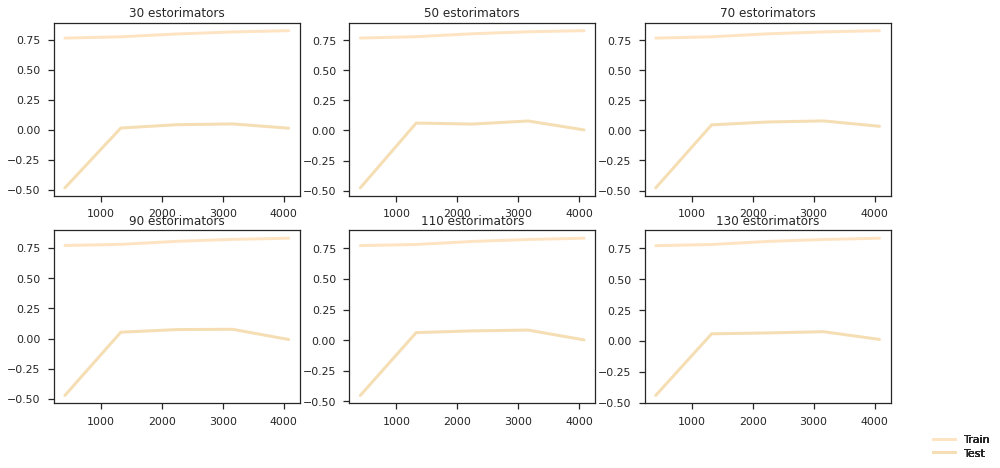

In [ ]:
plt.tight_layout(pad=3)
n_estimators = range(30, 150, 20)

for i, n_estimator in enumerate(n_estimators):
  RFRegressor = RandomForestRegressor(n_estimators=n_estimator)

  train_sizes, train_scores, test_scores = learning_curve(RFRegressor, X, y, 
                                                          scoring='r2', return_times=False)
  plt.subplot(2, 3, i+1)
  plt.plot(train_sizes, np.mean(train_scores, axis=1), color='bisque', linewidth=3)
  plt.plot(train_sizes, np.mean(test_scores, axis=1), color='wheat', linewidth=3)
  plt.title(f'{n_estimator} estorimators')
  plt.figlegend(['Train', 'Test'], loc ='lower right', labelspacing=0.3)

In [ ]:
RFRegressor = RandomForestRegressor(150, max_depth=35)
RFRegressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=35, n_estimators=150)

In [ ]:
RFRegressor.score(X_train, y_train), RFRegressor.score(X_test, y_test)

(0.8442603214093752, 0.45340172627044084)

##### Model Visualization

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass max_depth=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(418.5, 332.955, 'X[68] <= 0.5\nmse = 2.658\nsamples = 2589\nvalue = 5.898'),
 Text(209.25, 237.825, 'X[118] <= 0.5\nmse = 2.186\nsamples = 1619\nvalue = 5.499'),
 Text(104.625, 142.695, 'X[139] <= 0.5\nmse = 2.112\nsamples = 768\nvalue = 5.163'),
 Text(52.3125, 47.565, '\n  (...)  \n'),
 Text(156.9375, 47.565, '\n  (...)  \n'),
 Text(313.875, 142.695, 'X[8] <= 0.5\nmse = 2.065\nsamples = 851\nvalue = 5.795'),
 Text(261.5625, 47.565, '\n  (...)  \n'),
 Text(366.1875, 47.565, '\n  (...)  \n'),
 Text(627.75, 237.825, 'X[18] <= 0.5\nmse = 2.738\nsamples = 970\nvalue = 6.56'),
 Text(523.125, 142.695, 'X[80] <= 0.5\nmse = 1.981\nsamples = 673\nvalue = 6.192'),
 Text(470.8125, 47.565, '\n  (...)  \n'),
 Text(575.4375, 47.565, '\n  (...)  \n'),
 Text(732.375, 142.695, 'X[99] <= 0.5\nmse = 3.451\nsamples = 297\nvalue = 7.438'),
 Text(680.0625, 47.565, '\n  (...)  \n'),
 Text(784.6875, 47.565, '\n  (...)  \n')]

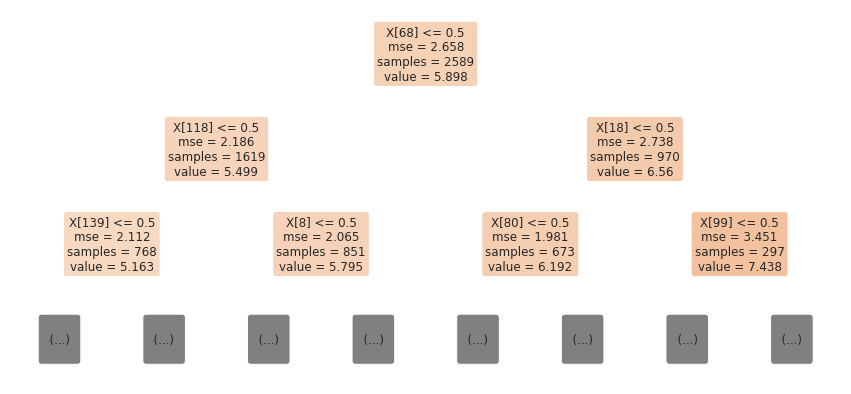

In [ ]:
plot_tree(RFRegressor.estimators_[5], 2, class_names='pIC50', filled=True, 
          impurity=True, rounded=True)

##### Prediction Result

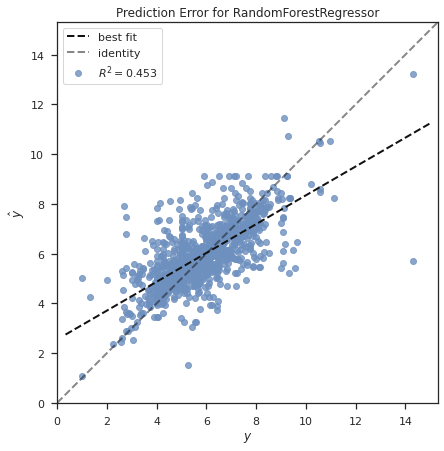

In [ ]:
prediction_error(RFRegressor, X_train, y_train, X_test, y_test, alpha=0.8);

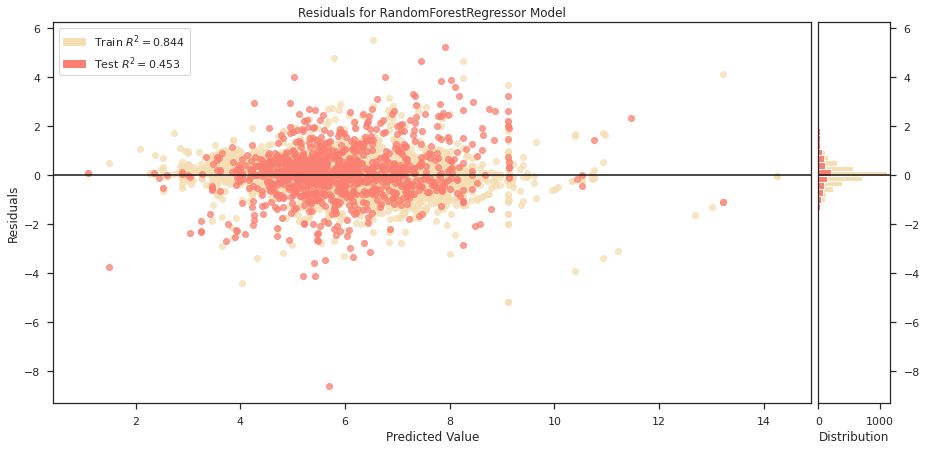

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b93d645d0>,
              estimator=RandomForestRegressor(max_depth=35, n_estimators=150),
              line_color=None, test_alpha=None, test_color=None,
              train_alpha=None, train_color=None)

In [ ]:
residuals_plot(RFRegressor, X_train, y_train, X_test, y_test, 
                     train_color='wheat', test_color='salmon')

#### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

Hyperparameters Tuning with GridSearchCV

In [ ]:
DecisionTreeRegressors = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=42), 
                            {'max_depth': [10, 20, 30, 35],
                             'max_features': [8, 10, 12, 15, 18]},
                              scoring='neg_mean_squared_error')

In [ ]:
DecisionTreeRegressors.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 30, 35],
                         'max_features': [8, 10, 12, 15, 18]},
             scoring='neg_mean_squared_error')

In [ ]:
pd.DataFrame(DecisionTreeRegressors.cv_results_).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011126,0.001507,0.001782,0.000283,10,8,"{'max_depth': 10, 'max_features': 8}",-1.788166,-1.549523,-1.716842,-1.924088,-1.745495,-1.744823,0.120781,4
1,0.009092,0.000205,0.001381,0.000194,10,10,"{'max_depth': 10, 'max_features': 10}",-1.927014,-1.581946,-1.717031,-1.808808,-1.747509,-1.756462,0.113065,5


In [ ]:
DTRegressor = DecisionTreeRegressors.best_estimator_

In [ ]:
DTRegressor.score(X_train, y_train), DTRegressor.score(X_test, y_test)

(0.6367643787747068, 0.26519265638490974)

##### Model Evaluation

We can take a look at `feature_importances_` attribute. These represent the importance value for each features used to predict the result

In [ ]:
DTRegressor.feature_importances_[:5]

array([0.09780203, 0.00110994, 0.00524341, 0.00708684, 0.00566286])

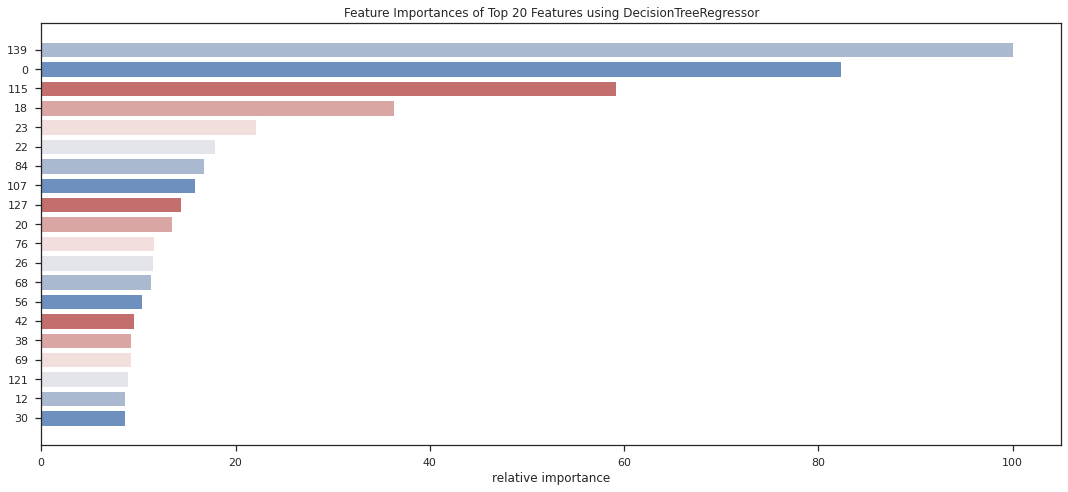

In [ ]:
feature_importances(DTRegressor, X_train, y_train, topn=20);

Decision Tree Model Learning Curve

In [ ]:
datasize, train_scores, test_scores = learning_curve(DTRegressor, X, y,
                                                    scoring='r2', return_times=False)

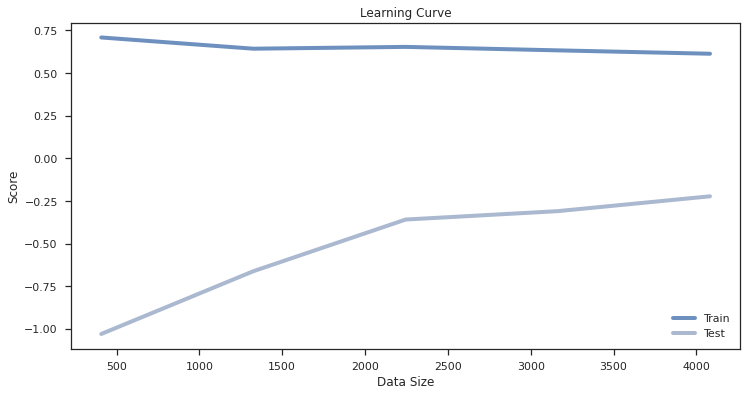

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(datasize, np.mean(train_scores, axis=1), linewidth=4)
plt.plot(datasize, np.mean(test_scores, axis=1), linewidth=4)
plt.title('Learning Curve')
plt.ylabel('Score')
plt.xlabel('Data Size')
plt.legend(['Train', 'Test']);

##### Model Visualization

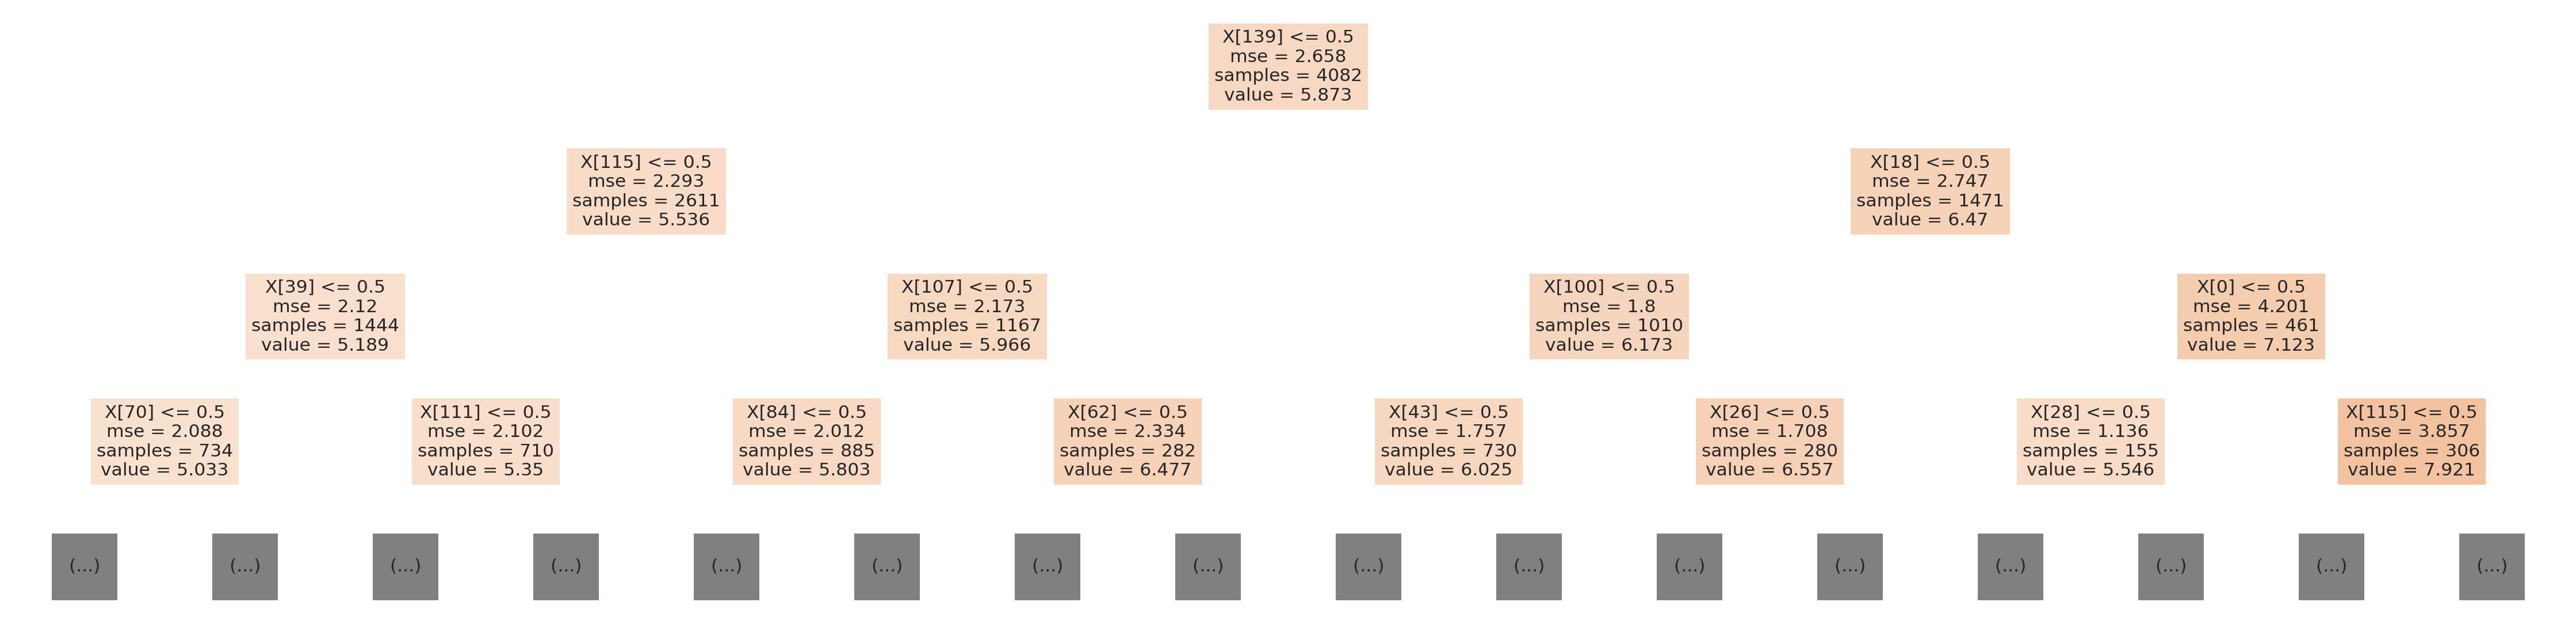

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(DTRegressor, max_depth=3, filled=True);

##### Result Visualization

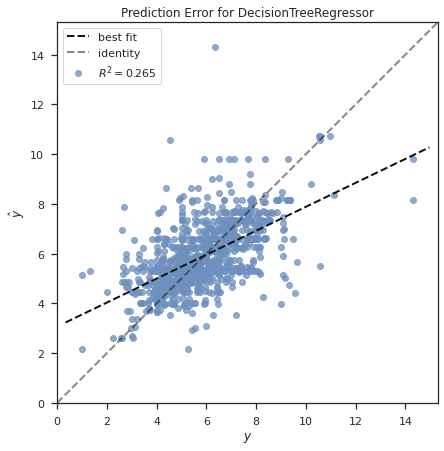

In [ ]:
prediction_error(DTRegressor, X_train, y_train, X_test, y_test);

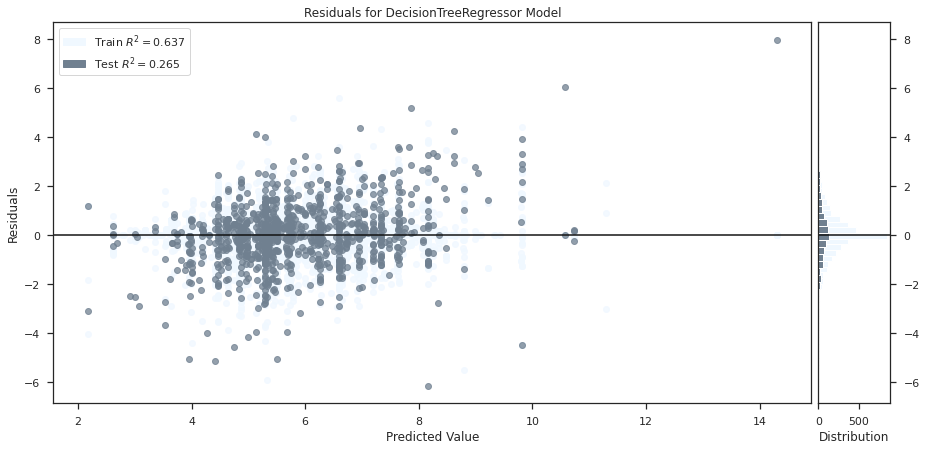

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b924ab390>,
              estimator=DecisionTreeRegressor(max_depth=10, max_features=18,
                                              random_state=42),
              line_color=None, test_alpha=None, test_color=None,
              train_alpha=None, train_color=None)

In [ ]:
residuals_plot(DTRegressor, X_train, y_train, X_test, y_test, 
                     train_color='aliceblue', test_color='slategray')

#### Gradient Boosting Model

Build `LGBMRegressor` model with `lightgbm`

ref: [Gradient boosting - machine learning mastery](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from lightgbm import plot_importance, plot_metric

Comparing different learning rates

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 1 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1080x504 with 0 Axes>

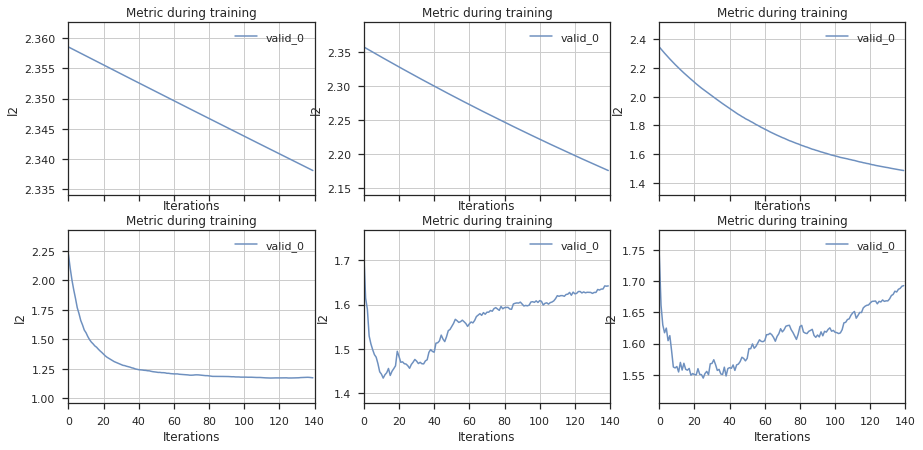

In [ ]:
lrs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1.1]
plt.tight_layout(pad=3.5, w_pad=.6, h_pad=.4)
fig, axs = plt.subplots(2, 3, sharex=True)

for i, lr in enumerate(lrs):
  lgmb = LGBMRegressor(n_estimators=140, learning_rate=lr, random_state=42)
  lgmb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
  if i < 3:
    ax = axs[0, i]
  else:
    ax = axs[1, i-3]
  plt.title(f'{lr} learning rates')
  plot_metric(lgmb, 'l2', figsize=(6,4), ax=ax)

In [ ]:
lgmb = LGBMRegressor(n_estimators=140, learning_rate=0.1, random_state=42)

In [ ]:
%%time
lgmb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

CPU times: user 956 ms, sys: 20 ms, total: 976 ms
Wall time: 521 ms


LGBMRegressor(n_estimators=140, random_state=42)

Display Features Importances attribute 

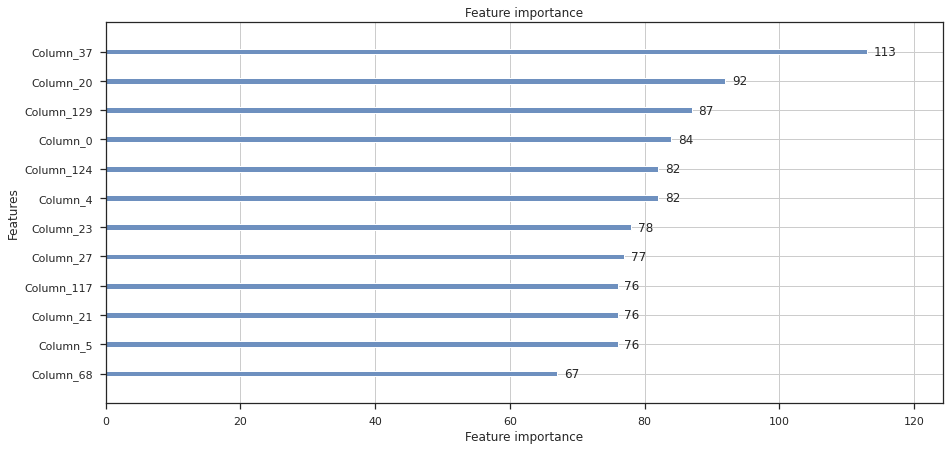

In [ ]:
plot_importance(lgmb, max_num_features=12)

##### Model Evaluation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import numpy as np

In [ ]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

for train_idx, val_idx in kfold.split(X):
  X_train, y_train = X[train_idx], y[train_idx]
  X_val, y_val = X[val_idx], y[val_idx]

train_pred = lgmb.predict(X_train)
val_pred = lgmb.predict(X_val)

train_csv = cross_val_score(lgmb, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=kfold)
val_csv = cross_val_score(lgmb, X_val, y_val, 
                          scoring='neg_mean_absolute_error')

print(f'Training Cross-Validation Score: {np.mean(train_csv): >4f}')
print(f'Validation-set Cross-Validation Score: {np.mean(train_csv): >4f}')

Training Cross-Validation Score: -0.800646
Validation-set Cross-Validation Score: -0.800646


#####Model Visualization

In [ ]:
from lightgbm import create_tree_digraph

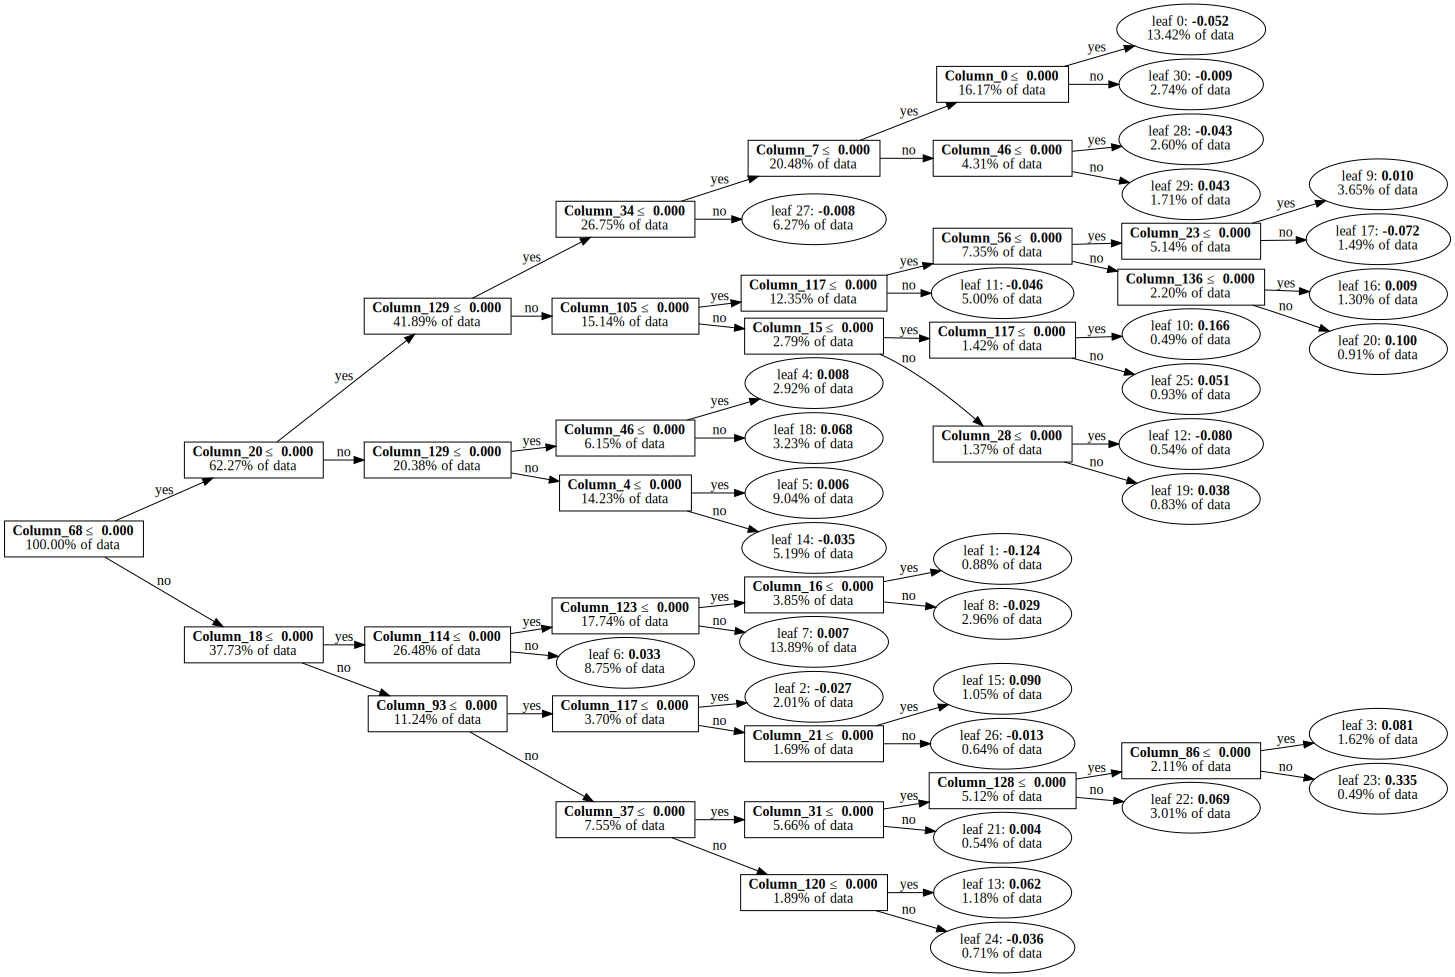

In [ ]:
create_tree_digraph(lgmb, tree_index=11, show_info='data_percentage')

##### Result Visualization

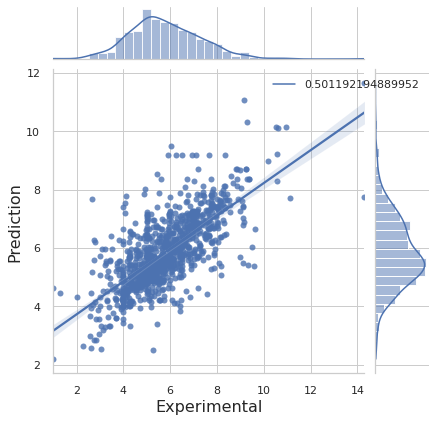

In [ ]:
test_pred = lgmb.predict(X_test)
test_r2 = r2_score(y_test, test_pred)
f = sns.jointplot(x=y_test, y=test_pred, kind='reg', palette='lagv')
f.set_axis_labels(xlabel='Experimental', ylabel='Prediction', size=16)
plt.legend([test_r2], loc='upper right');

### Comparing Models

comparing different ML algorithms for build regression models

In [ ]:
!pip install lazypredict -U --quiet

In [ ]:
from lazypredict.Supervised import LazyRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
train_model, train_results = reg.fit(X_train, X_train, y_train, y_train)

100%|██████████| 42/42 [01:05<00:00,  1.57s/it]


In [ ]:
train_results.sort_values(['R-Squared', 'RMSE'], ascending=False).head()

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.86,0.87,0.60,0.17
ExtraTreeRegressor,0.86,0.87,0.60,0.18
ExtraTreesRegressor,0.86,0.87,0.60,6.59
GaussianProcessRegressor,0.86,0.87,0.60,6.60
RandomForestRegressor,0.82,0.83,0.67,5.13


#### Visualize Models' Performance

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette(palette='vlag', color_codes=True)
sns.set_theme(style="whitegrid")

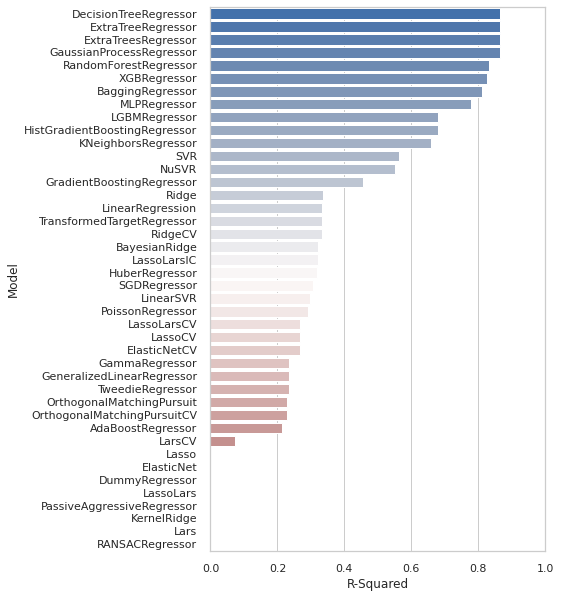

In [ ]:
plt.figure(figsize=(6, 10))
ax = sns.barplot(y=train_results.index, x="R-Squared", data=train_results, 
                 palette='vlag')
ax.set(xlim=(0, 1));

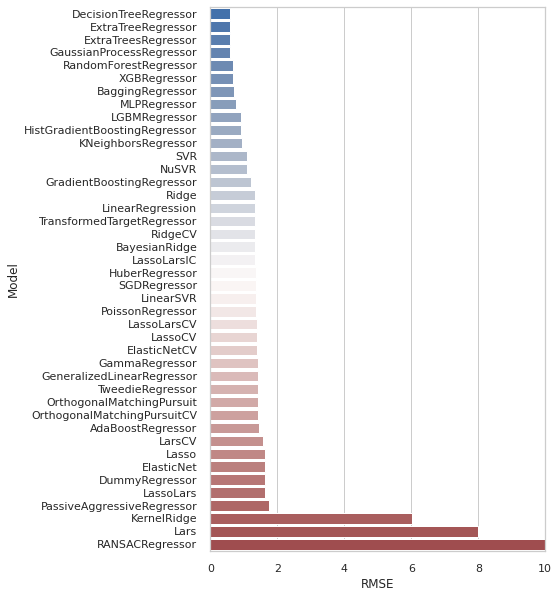

In [ ]:
plt.figure(figsize=(6, 10))
ax = sns.barplot(y=train_results.index, x="RMSE", data=train_results, 
                 palette='vlag')
ax.set(xlim=(0, 10));

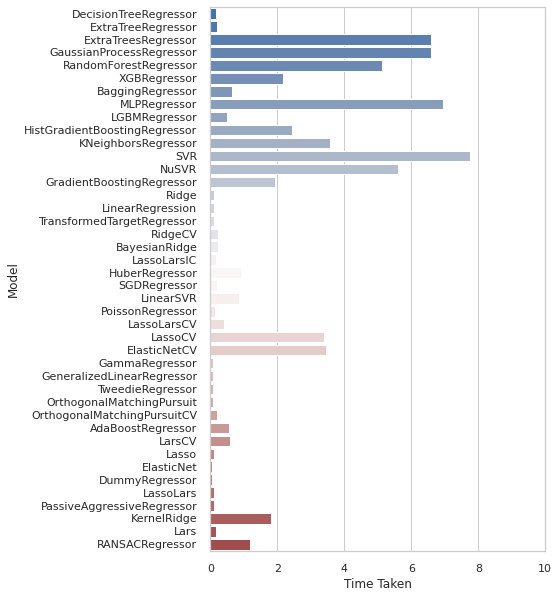

In [ ]:
plt.figure(figsize=(6, 10))
ax = sns.barplot(y=train_results.index, x="Time Taken", data=train_results,
                 palette='vlag')
ax.set(xlim=(0, 10));